In [1]:
import numpy as np
import mne
import pyxdf
import matplotlib.pyplot as plt
from pathlib import Path

from scipy import signal

from util import preprocess_util

%load_ext autoreload
%autoreload 2

DATA_DIR = Path('./data')
DATA_FILE_NAME = 'Sandra_MI_1h.xdf'
DATA_FILE = DATA_DIR / DATA_FILE_NAME

# Read in xdf file(s)

In [2]:
# Read data
streams, header = pyxdf.load_xdf(DATA_FILE)

In [3]:
# Extract streams from xdf data

def find_stream(name, streams):
    for stream in streams:
        if stream['info']['name'][0] == name:
            return stream
    
    print(f'Error: stream "{name}" not found')

unicorn_stream = find_stream('Unicorn', streams)
fs = int(unicorn_stream['info']['nominal_srate'][0]) # 250 Hz

openvibe_stream = find_stream('openvibeMarkers', streams)
openvibe_stream['time_series'] = np.array(openvibe_stream['time_series'])

print(f"EEG data shape: {unicorn_stream['time_series'].shape}")
print(f"Markers shape: {openvibe_stream['time_series'].shape}")
print(f'Sampling Frequency: {fs}')

EEG data shape: (1023780, 17)
Markers shape: (1213, 1)
Sampling Frequency: 250


# Extract Event Data

From the Open Vibe Marker Stream

- `event_codes`: array of codes sent to the marker stream at the start of each event 
- `event_time_stamps`: array of timestamps signifying the start of each event

The mapping for this particular paradigm was:
- 'beep': 0, 
- 'cue_no_blink': 1, 
- 'imagery_no_blink': 2, 
- 'break': 3, 
- 'cue_handR': 4, 
- 'imagery_handR': 5, 
- 'cue_handL': 6, 
- 'imagery_handL': 7

In [4]:
def unique(input_list):
    unique_items = []
    for x in input_list:
        if x not in unique_items:
            unique_items.append(x)
    
    return unique_items

def build_unique_mapping(unique_labels):
    unique_mapping = {}
    for i, label in enumerate(unique_labels):
        unique_mapping[label] = i
    
    return unique_mapping

In [5]:
# Get event codes
event_labels = [x[0] for x in openvibe_stream['time_series']]
unique_labels = unique(event_labels)
label2code = build_unique_mapping(unique_labels)
event_codes = np.array([label2code[x] for x in event_labels])

# Get event time stamps
event_time_stamps = np.array(openvibe_stream['time_stamps'])

assert event_time_stamps.shape == event_codes.shape

print(f'Total number of events: {event_codes.shape[0]}')
print(f'Event code for left MI: {label2code["imagery_handL"]}')
print(f'Event code for left MI: {label2code["imagery_handR"]}')
print(f'Number of left MI events: {np.sum(event_codes == label2code["imagery_handL"])}')
print(f'Number of right MI events: {np.sum(event_codes == label2code["imagery_handR"])}')

Total number of events: 1213
Event code for left MI: 7
Event code for left MI: 5
Number of left MI events: 200
Number of right MI events: 200


# Preprocess EEG data

In [6]:
def channel2name(channel_number):
    mapping = {
        0:  'Fz',    
        1:  'C3', 
        2:  'Cz', 
        3:  'C4',
        4:  'Pz', 
        5:  'PO7', 
        6:  'Oz', 
        7:  'PO8',
    }
    return mapping[channel_number]

def name2channel(name):
    mapping = {
        'Fz': 0,    
        'C3': 1, 
        'Cz': 2, 
        'C4': 3,
        'Pz': 4, 
        'PO7': 5,
        'Oz': 6, 
        'PO8': 7,
    }
    return mapping[name]

def get_channel(channel_name:str, eeg_data):
    '''
    Params:
        - channel_name: One of [Fz, C3, Cz, C4, Pz, P07, Oz, PO8]
        - eeg_data: shape (num_channels, num_samples)
    Returns:
        - single channel
    '''
    return eeg_data[name2channel[channel_name], :]


In [7]:
# Extract the relevent EEG channels
eeg_data = unicorn_stream['time_series'][:,0:8].T
eeg_data.shape

(8, 1023780)

## Rereference the EEG data

In [8]:
# Rereference according to the mean
eeg_data = eeg_data - np.mean(eeg_data, axis=0)

## Filter EEG data

In [220]:
lf = 6
hf = 35
nf = 50

# Design notch filter
b, a = signal.iirnotch(w0=nf, Q=7, fs=fs)
freq, h = signal.freqz(b, a, fs = fs)

# Plot the notch filter TF
# plt.figure()
# plt.plot( freq, 20*np.log10(abs(h)))
# plt.title('Notch Filter')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('|H(f)| dB')
# plt.show()

# Apply notch and bandpass filters
eeg_notched = signal.filtfilt(b, a, eeg_data, axis=1)
eeg_notched_bp = preprocess_util.bandpass(eeg_notched, lf=lf, hf=hf, fs=fs, ftype='butter')

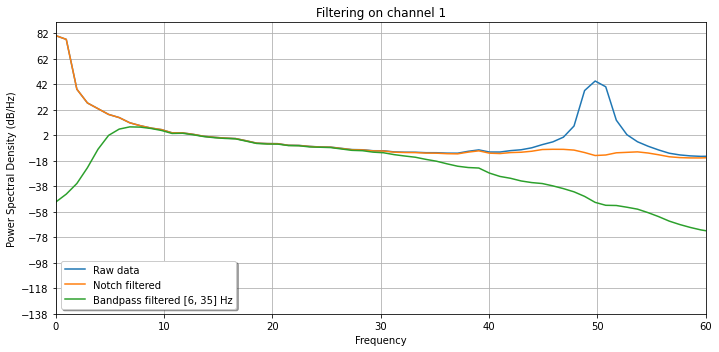

In [221]:
channel_number = name2channel('C3')

# Show the effect of the filter
plt.figure(figsize=(10,5))
plt.title(f'Filtering on channel {channel_number}')
plt.psd(eeg_data[channel_number], Fs=fs, label='Raw data')
plt.psd(eeg_notched[channel_number], Fs=fs, label='Notch filtered')
plt.psd(eeg_notched_bp[channel_number], Fs=fs, label=f'Bandpass filtered [{lf}, {hf}] Hz')
plt.tight_layout()
plt.legend(loc='lower left', shadow=True)
plt.xlim([0,60])
plt.show()

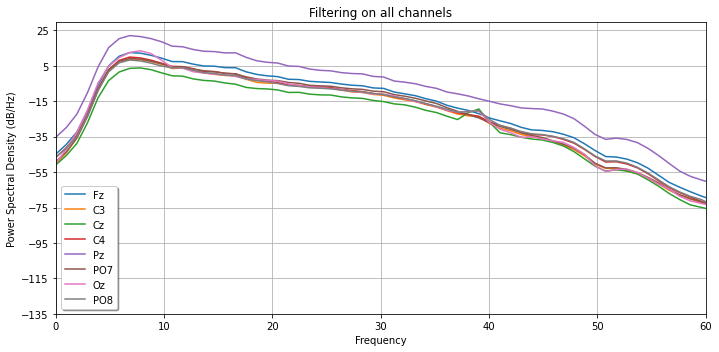

In [219]:
plt.figure(figsize=(10,5))
plt.title(f'Filtering on all channels')

for i in range(eeg_data.shape[0]):
    plt.psd(eeg_notched_bp[i], Fs=fs, label=f'{channel2name(i)}')

plt.tight_layout()
plt.legend(loc='lower left', shadow=True)
plt.xlim([0,60])
plt.show()

# Build an event time-series/stream

Create a time series from the event codes which is the same length as the EEG data

In [124]:
eeg_timestamps = unicorn_stream['time_stamps']
eeg_start_time = eeg_timestamps[0]
label_start_time = event_time_stamps[0]
experiment_start_time = min(label_start_time, eeg_start_time)

relative_eeg_timestamps = eeg_timestamps - experiment_start_time
relative_event_time_stamps = event_time_stamps - experiment_start_time

In [125]:
def find_closest_time(timestamp, eeg_timestamps):
    return np.where(eeg_timestamps > timestamp)[0][0]

In [126]:
# Get indices of events
indices = [0]

for timestamp in relative_event_time_stamps:
    indices.append(find_closest_time(timestamp, relative_eeg_timestamps))

# Build event time series (use -1 since 0 is actually a code for no blinking)
event_time_series = np.zeros_like(eeg_timestamps) - 1

for i, (_, code) in enumerate(zip(indices[1:], event_codes)):
    idx = i+1
    if idx < len(indices)-1:
        event_time_series[indices[idx]:indices[idx+1]] = code
    else:
        event_time_series[indices[idx]:] = code

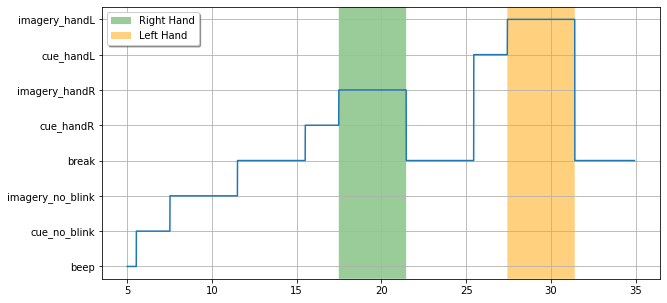

In [127]:
window = 30
start_time = 5
t = np.arange(0, window*fs, 1/fs)

fig, ax = plt.subplots(figsize=(10,5))
x = relative_eeg_timestamps[start_time*fs:(start_time + window)*fs]
y = event_time_series[start_time*fs:(start_time + window)*fs]
ax.plot(x, y, '-')

import matplotlib.transforms as mtransforms
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)

ax.fill_between(x, 0, 1, where= (y == 5),
                facecolor='green', alpha=0.4, transform=trans, label='Right Hand')
ax.fill_between(x, 0, 1, where= (y == 7),
                facecolor='orange', alpha=0.5, transform=trans, label='Left Hand')

event_labels = list(label2code.keys())
plt.yticks(range(len(event_labels)), event_labels)
plt.grid()
plt.legend(shadow=True)
plt.show()

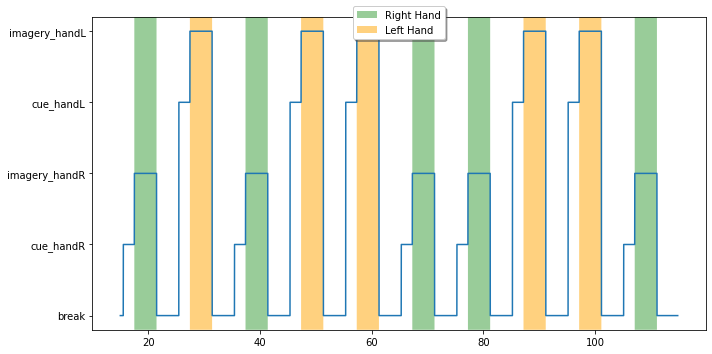

In [128]:
window = 100
start_time = 15
x = relative_eeg_timestamps[start_time*fs:(start_time + window)*fs]
y = event_time_series[start_time*fs:(start_time + window)*fs]

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(x, y)

import matplotlib.transforms as mtransforms
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)

ax.fill_between(x, 0, 1, where= (y == 5),
                facecolor='green', alpha=0.4, transform=trans, label='Right Hand')
ax.fill_between(x, 0, 1, where= (y == 7),
                facecolor='orange', alpha=0.5, transform=trans, label='Left Hand')

event_labels = list(label2code.keys())
plt.yticks(range(len(event_labels)), event_labels)
plt.ylim([2.8,7.2])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), shadow=True, fancybox=True)
plt.tight_layout()
plt.show()

# Normalise EEG data

In [240]:
def normalise_eeg(eeg_data):
    '''Normalise each channel to have std of 1'''
    return eeg_notched_bp / eeg_notched_bp.std(axis=1)[:, None]

In [241]:
eeg_notched_bp_norm = normalise_eeg(eeg_notched_bp)

# Inspect EEG data with markers

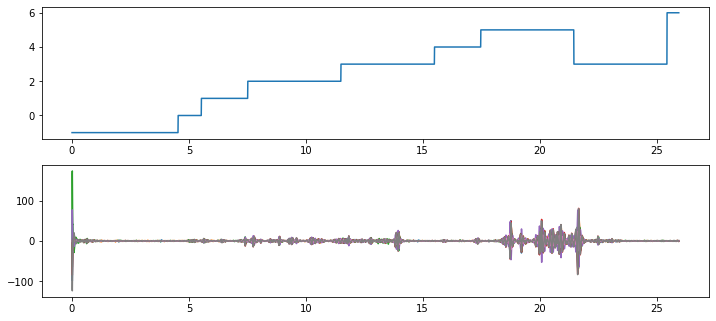

In [244]:
window = 26
start_time = 0
number_of_channels = 8

plt.subplots(figsize=(10,20), sharex=True)
plt.tight_layout()

x = relative_eeg_timestamps[start_time*fs:(start_time + window)*fs]
y1 = event_time_series[start_time*fs:(start_time + window)*fs]
plt.subplot((number_of_channels + 1),1,1)
plt.plot(x, y1)

for i in range(number_of_channels):
    y2 = eeg_notched_bp_norm[i ,start_time*fs:(start_time + window)*fs]
    plt.subplot((number_of_channels + 1), 1, 2)
    plt.plot(x, y2)

plt.show()

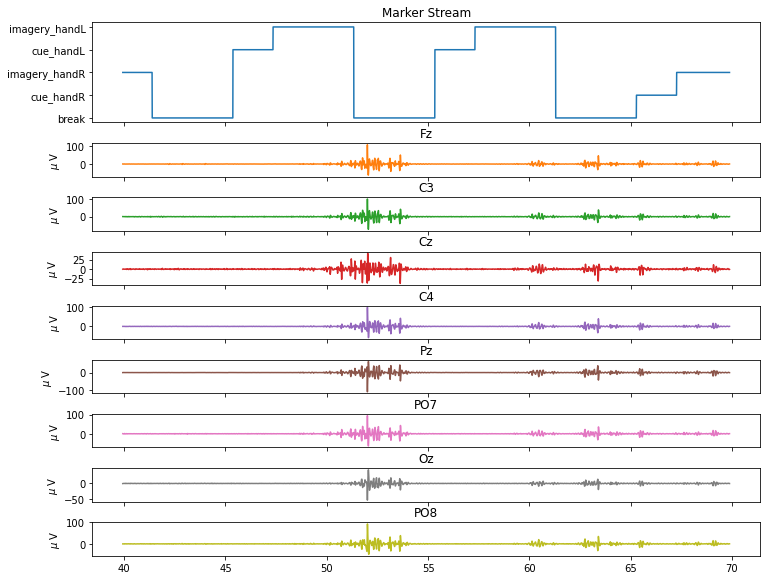

In [245]:
def plot_all(eeg_timestamps, event_time_series, eeg_data, number_of_channels=None, window=30, start_time = 15):

    if number_of_channels == None:
        number_of_channels = eeg_data.shape[0]

    colors = plt.rcParams["axes.prop_cycle"]()

    height_ratios = [1 if i>0 else 3 for i in range(number_of_channels+1)]

    fig, axs = plt.subplots(
        number_of_channels+1, 1,
        figsize=(10,8), 
        sharex=True, 
        gridspec_kw={'height_ratios': height_ratios}
    )
    plt.tight_layout()

    x = eeg_timestamps[start_time*fs:(start_time + window)*fs]
    y = event_time_series[start_time*fs:(start_time + window)*fs]

    c = next(colors)["color"]
    axs[0].plot(x, y, color=c)
    axs[0].set_title('Marker Stream')
    plt.sca(axs[0])
    plt.yticks(range(len(event_labels)), event_labels)
    axs[0].set_ylim([2.8,7.2])

    for i in range(number_of_channels):
        axs[i+1].plot(
            x, 
            eeg_data[i ,start_time*fs:(start_time + window)*fs], 
            color=next(colors)["color"]
        )
        axs[i+1].set_title(channel2name(i))
        axs[i+1].set_ylabel(r'$\mu$ V')

    plt.show()

plot_all(relative_eeg_timestamps, event_time_series, eeg_notched_bp_norm, start_time=40)

# Save the data

In [46]:
data_file_name = DATA_FILE_NAME.split('.')[0]
np.save(DATA_DIR / f'{data_file_name}_eeg_data', eeg_notched_bp, allow_pickle=True)
np.save(DATA_DIR / f'{data_file_name}_marker_stream', eeg_notched_bp, allow_pickle=True)

# ICA Experiment

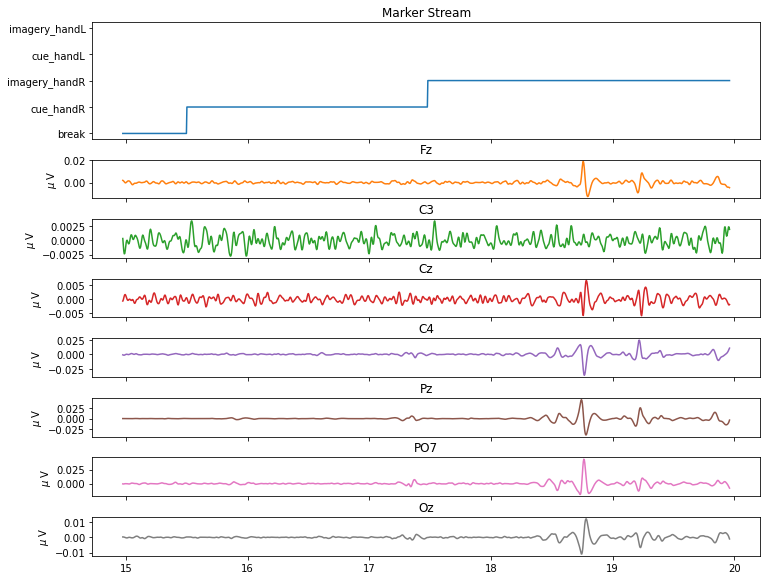

In [263]:
from sklearn.decomposition import FastICA

transformer = FastICA(n_components=7, random_state=0, whiten=True)


_transformed = transformer.fit_transform(eeg_notched_bp.T)
_transformed.shape

plot_all(relative_eeg_timestamps, event_time_series, _transformed.T, window=5, number_of_channels=7)

# Split into trials

In [246]:
EEG = eeg_notched_bp_norm.copy()
event_onsets = event_time_stamps.copy()
cl_labs = ['imagery_handL', 'imagery_handR']
cl_codes = [label2code[code] for code in cl_labs]
nclasses = len(cl_labs)
nchannels = EEG.shape[0]

# Print some information
print('Shape of EEG:', EEG.shape)
print('Sample rate:', fs)
print('Number of channels:', EEG.shape[0])
print('Channel names:', [channel2name(channel) for channel in range(EEG.shape[0])])
print('Number of events:', len(event_onsets))
print('Event codes:', np.unique(event_codes))
print('Class labels:', cl_labs)
print('Class codes:', cl_codes)
print('Number of classes:', nclasses)
# print(event_codes)

Shape of EEG: (8, 1023780)
Sample rate: 250
Number of channels: 8
Channel names: ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8']
Number of events: 1213
Event codes: [0 1 2 3 4 5 6 7]
Class labels: ['imagery_handL', 'imagery_handR']
Class codes: [7, 5]
Number of classes: 2


In [247]:
# Dictionary to store the trials in, each class gets an entry
trials = {}
markers = {} 

# The time window (in samples) to extract for each trial, here 0.5 -- 2.5 seconds
win = np.arange(int(0.5*fs), int(2.5*fs))

# Length of the time window
nsamples = len(win)

for cl_lab in cl_labs:
    event_onset_mask =  np.roll(event_time_series,1)!=event_time_series
    class_onset_mask = event_time_series == label2code[cl_lab]
    class_onset_indices = np.where(np.logical_and(
                                event_onset_mask, class_onset_mask))[0]
    
    # Allocate memory for the trials
    trials[cl_lab] = np.zeros((nchannels, nsamples, len(class_onset_indices)))
    markers[cl_lab] = np.zeros((nsamples, len(class_onset_indices)))

    # Extract each trial
    for i, onset in enumerate(class_onset_indices):
        trials[cl_lab][:,:,i] = EEG[:, win+onset]
        markers[cl_lab][:, i] = event_time_series[win+onset]

print(trials['imagery_handL'].shape, trials['imagery_handR'].shape)

(8, 500, 200) (8, 500, 200)


# Some statistical Analysis to remove noisy trials

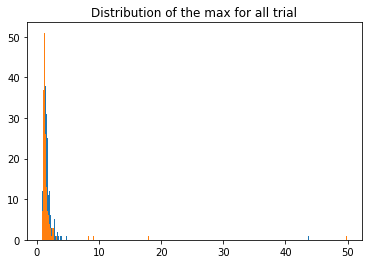

In [248]:
# check the distribution of the max_val
plt.figure()
plt.title('Distribution of the max for all trial')
plt.hist(trials['imagery_handL'].max(axis = (0,1)), bins='auto', label='Left MI Trials')
plt.hist(trials['imagery_handR'].max(axis = (0,1)), bins='auto', label='Right MI Trials')
plt.show()

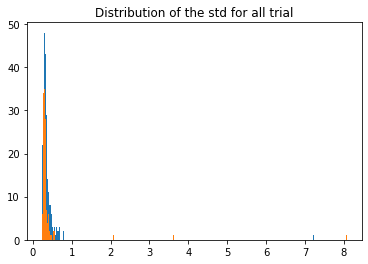

In [249]:
plt.figure()
plt.title('Distribution of the std for all trial')
plt.hist(trials['imagery_handL'].std(axis = (0,1)), bins='auto', label='Left MI Trials')
plt.hist(trials['imagery_handR'].std(axis = (0,1)), bins='auto', label='Right MI Trials')
plt.show()

In [250]:
# remove bad trials

good_trials = {
    'imagery_handL': np.zeros((nchannels, nsamples,1)),
    'imagery_handR': np.zeros((nchannels, nsamples,1)),
} 

for trial in range(trials['imagery_handL'].shape[2]):
    eeg_sampleL = trials['imagery_handL'][:,:,trial]
    if eeg_sampleL.std(axis = (0,1)) < 0.7 and eeg_sampleL.max(axis = (0,1)) < 4:
        good_trials['imagery_handL'] = np.concatenate(
            [good_trials['imagery_handL'], np.expand_dims(eeg_sampleL, -1)], 
            axis=2
        )

    eeg_sampleR = trials['imagery_handR'][:,:,trial]
    if eeg_sampleR.std(axis = (0,1)) < 0.7 and eeg_sampleR.max(axis = (0,1)) < 4:
        good_trials['imagery_handR'] = np.concatenate(
            [good_trials['imagery_handR'], np.expand_dims(eeg_sampleR, -1)],
            axis=2
        )

good_trials['imagery_handR'] = good_trials['imagery_handR'][:,:,1:]
good_trials['imagery_handL'] = good_trials['imagery_handL'][:,:,1:]

print(good_trials['imagery_handL'].shape)
print(good_trials['imagery_handR'].shape)

(8, 500, 196)
(8, 500, 196)


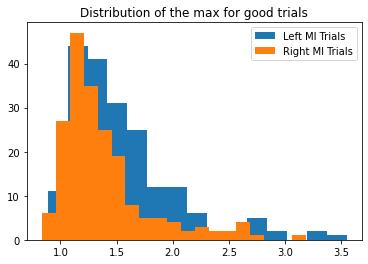

In [251]:
# check the distribution of the max_val
plt.figure()
plt.title('Distribution of the max for good trials')
plt.hist(good_trials['imagery_handL'].max(axis = (0,1)), bins='auto', label='Left MI Trials')
plt.hist(good_trials['imagery_handR'].max(axis = (0,1)), bins='auto', label='Right MI Trials')
plt.legend()
plt.show()

In [252]:
good_trials['imagery_handR'].max(axis = (0,1,2))

3.1837450832729277

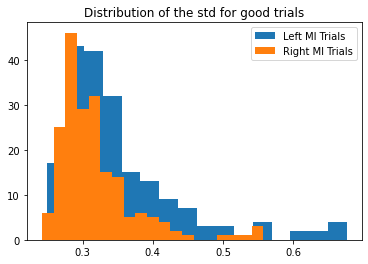

In [253]:
# check the distribution of the max_val
plt.figure()
plt.title('Distribution of the std for good trials')
plt.hist(good_trials['imagery_handL'].std(axis = (0,1)), bins='auto', label='Left MI Trials')
plt.hist(good_trials['imagery_handR'].std(axis = (0,1)), bins='auto', label='Right MI Trials')
plt.legend()
plt.show()

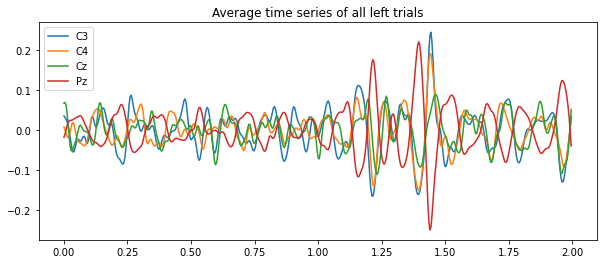

In [260]:
av_left_trials = trials['imagery_handL'].mean(axis = 2)
av_left_trials.shape
plt.figure(figsize=(10,4))
plt.tight_layout()

t = np.arange(0, int(av_left_trials.shape[1]/250), 1/fs)
for name in ['C3', 'C4', 'Cz', 'Pz']:
    plt.plot(t, av_left_trials[name2channel(name)], label=name)
    
plt.title('Average time series of all left trials')
plt.legend()
plt.show()

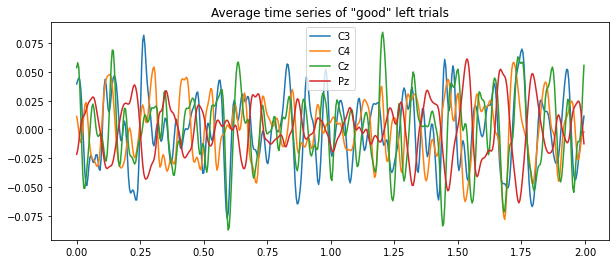

In [261]:
av_left_trials = good_trials['imagery_handL'].mean(axis = 2)
plt.figure(figsize=(10,4))
plt.tight_layout()

t = np.arange(0, int(av_left_trials.shape[1]/250), 1/fs)
for name in ['C3', 'C4', 'Cz', 'Pz']:
    plt.plot(t, av_left_trials[name2channel(name)], label=name)
    
plt.title('Average time series of "good" left trials')    
plt.legend()
plt.show()